In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install numpy==1.25.0
!pip install gensim

In [2]:
import numpy as np
print(np.__version__)

1.25.0


In [11]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
# dataset = merged
dataset_path = "/content/drive/MyDrive/sarcastic_headlines.csv"
df = pd.read_csv(dataset_path)

In [13]:
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [14]:
df.isnull().any()

,0
headline,False
is_sarcastic,False


In [15]:
def clean_headline(headline, rule="lemmatize"):
    """
    Cleans a single news headline based on the given rule ("lemmatize" or "stem").
    Removes punctuation, stopwords, numbers (optional), and performs normalization.
    """
    # Lowercase
    headline = headline.lower()

    # Remove URLs (just in case)
    headline = re.sub(r"http\S+|www\S+|https\S+", '', headline, flags=re.MULTILINE)

    # Remove punctuation
    headline = re.sub(r"[^\w\s]", '', headline)

    # Remove numbers (optional — remove if not desired)
    headline = re.sub(r"\d+", '', headline)

    # Tokenize
    tokens = headline.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize or stem
    if rule == "lemmatize":
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    elif rule == "stem":
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]
    else:
        raise ValueError("Invalid rule. Choose 'lemmatize' or 'stem'.")

    return " ".join(tokens)


In [20]:
df['cleaned_headline'] = df['headline'].apply(lambda x: clean_headline(x, rule="lemmatize"))


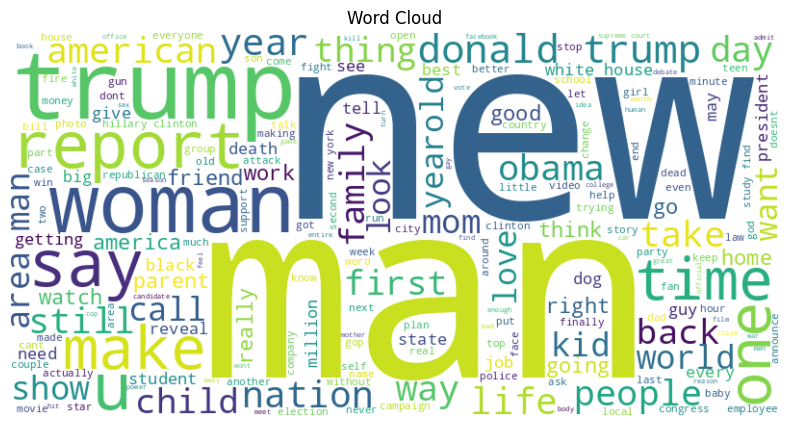

In [21]:
all_clean_text = " ".join(df['cleaned_headline'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_clean_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

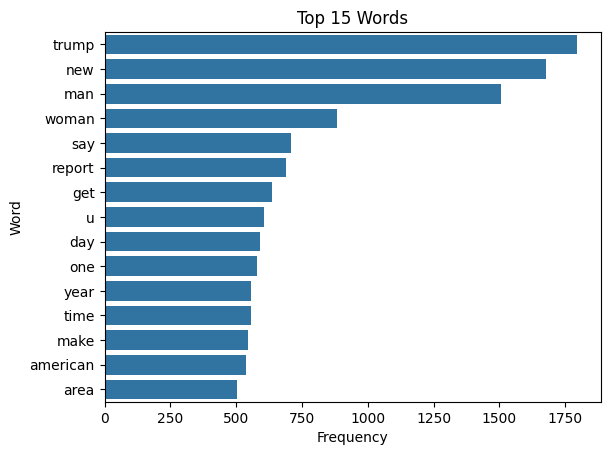

In [22]:
word_freq = Counter(" ".join(df["cleaned_headline"]).split())
common_words = pd.DataFrame(word_freq.most_common(15), columns=['Word', 'Frequency'])
sns.barplot(data=common_words, x='Frequency', y='Word')
plt.title("Top 15 Words")
plt.show()

In [24]:
# TOKENIZATION + PADDING
X = df['cleaned_headline'].values
y = df['is_sarcastic'].values

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size: ",vocab_size)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

max_len = int(np.percentile([len(x) for x in X_train_seq], 95))
print("\nMax Length: ",max_len)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

Vocab size:  22567

Max Length:  11


In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

In [28]:
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.build(input_shape=(None, max_len))
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 11, 64)         │     1,444,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,452,609 (5.54 MB)

 Trainable params: 1,452,609 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model1_history = model1.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6976 - loss: 0.5551

358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6978 - loss: 0.5549 - val_accuracy: 0.8157 - val_loss: 0.4035
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9326 - loss: 0.1817 - val_accuracy: 0.8022 - val_loss: 0.4719
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9834 - loss: 0.0529 - val_accuracy: 0.7935 - val_loss: 0.6859
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9942 - loss: 0.0200 - val_accuracy: 0.7855 - val_loss: 0.7865
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9983 - loss: 0.0078 - val_accuracy: 0.7909 - val_loss: 0.9074


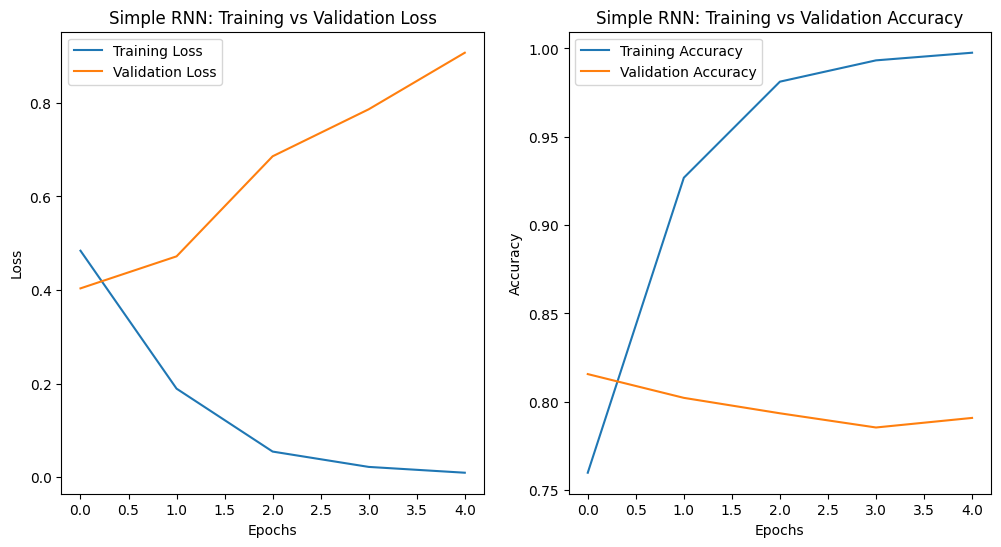

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model1_history.history['loss'], label='Training Loss')
plt.plot(model1_history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model1_history.history['accuracy'], label='Training Accuracy')
plt.plot(model1_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Simple RNN: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
  loss, accuracy = model1.evaluate(X_val_pad, y_val, verbose=0)
  print('Test Loss:', loss)
  print('\nTest Accuracy:', accuracy)
  y_pred = (model1.predict(X_val_pad) > 0.5).astype(int)
  print(f"\n\nSimple RNN Accuracy: {accuracy_score(y_val, y_pred):.4f}")
  print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
  print("Classification Report:\n", classification_report(y_val, y_pred))

Test Loss: 0.40347570180892944

Test Accuracy: 0.8156883120536804
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Simple RNN Accuracy: 0.8157
Confusion Matrix:
 [[2594  401]
 [ 654 2075]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      2995
           1       0.84      0.76      0.80      2729

    accuracy                           0.82      5724
   macro avg       0.82      0.81      0.81      5724
weighted avg       0.82      0.82      0.81      5724



In [32]:
model1.save('model1.h5')

In [33]:
# LSTM with trainable embedding
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.build(input_shape=(None, max_len))
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 11, 64)         │     1,444,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,477,377 (5.64 MB)

 Trainable params: 1,477,377 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model2_history = model2.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6738 - loss: 0.5750 - val_accuracy: 0.8056 - val_loss: 0.4211
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8930 - loss: 0.2646 - val_accuracy: 0.8057 - val_loss: 0.4528
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9425 - loss: 0.1624 - val_accuracy: 0.8028 - val_loss: 0.5077
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9630 - loss: 0.1066 - val_accuracy: 0.7918 - val_loss: 0.6765
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9788 - loss: 0.0648 - val_accuracy: 0.7970 - val_loss: 0.7045


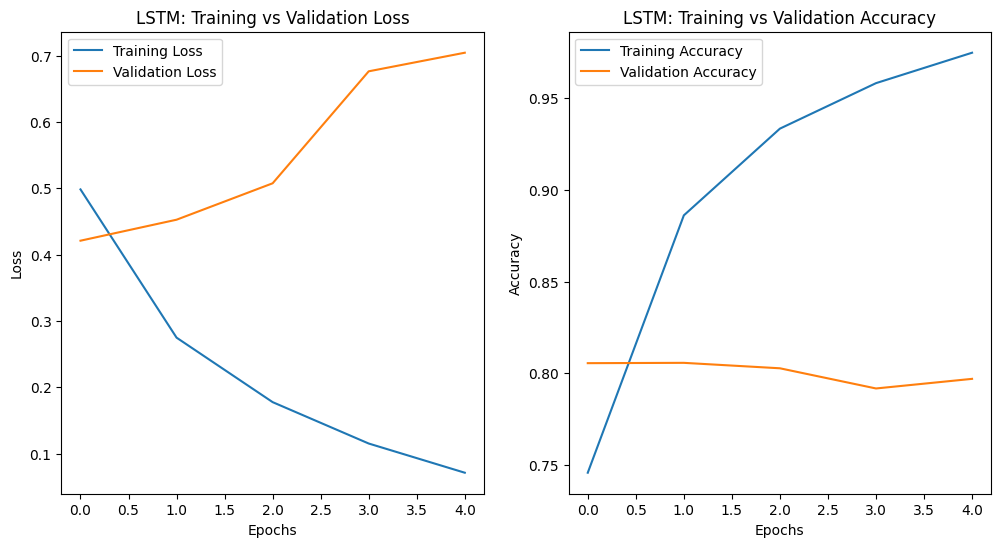

In [37]:
# Visualize model2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model2_history.history['loss'], label='Training Loss')
plt.plot(model2_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model2_history.history['accuracy'], label='Training Accuracy')
plt.plot(model2_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
#Evaluate model2
loss, accuracy = model2.evaluate(X_val_pad, y_val, verbose=0)
print('Test Loss:', loss)
print('\nTest Accuracy:', accuracy)
y_pred = (model2.predict(X_val_pad) > 0.5).astype(int)
print(f"\n\nLSTM Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Test Loss: 0.4211250841617584

Test Accuracy: 0.8055555820465088
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


LSTM Accuracy: 0.8056
Confusion Matrix:
 [[2432  563]
 [ 550 2179]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      2995
           1       0.79      0.80      0.80      2729

    accuracy                           0.81      5724
   macro avg       0.81      0.81      0.81      5724
weighted avg       0.81      0.81      0.81      5724



In [42]:
model2.save('model2.h5')

In [43]:
import gensim.downloader as api

In [44]:
embedding_model = api.load('glove-wiki-gigaword-50')
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

[==================================================] 100.0% 66.0/66.0MB downloaded


In [45]:
model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,128,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,128,350 (4.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,128,350 (4.30 MB)

In [46]:
model3_history = model3.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6531 - loss: 0.6105 - val_accuracy: 0.7421 - val_loss: 0.5275
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7601 - loss: 0.4980 - val_accuracy: 0.7666 - val_loss: 0.4837
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7858 - loss: 0.4584 - val_accuracy: 0.7633 - val_loss: 0.4712
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7952 - loss: 0.4363 - val_accuracy: 0.7809 - val_loss: 0.4530
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8128 - loss: 0.4100 - val_accuracy: 0.7839 - val_loss: 0.4491
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8263 - loss: 0.3851 - val_accuracy: 0.7849 - val_loss: 0.4556
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8362 - loss: 0.3629 - val_accuracy: 0.7825 - val_loss: 0.4526
Epoch 8/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8464 - loss: 0.3480 - val_accuracy: 0.

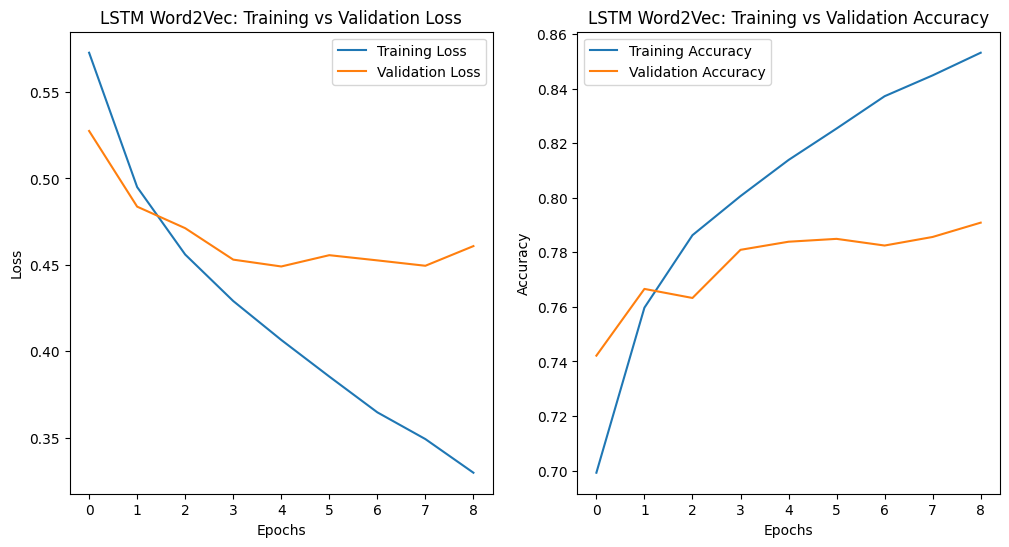

In [47]:
# Visualize model3
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model3_history.history['loss'], label='Training Loss')
plt.plot(model3_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Word2Vec: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model3_history.history['accuracy'], label='Training Accuracy')
plt.plot(model3_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Word2Vec: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
# Evaluate model 3
loss, accuracy = model3.evaluate(X_val_pad, y_val, verbose=0)
print('Test Loss:', loss)
print('\nTest Accuracy:', accuracy)
y_pred = (model3.predict(X_val_pad) > 0.5).astype(int)
print(f"\n\nLSTM : {accuracy_score(y_val, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Test Loss: 0.44906771183013916

Test Accuracy: 0.7838923931121826
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


LSTM : 0.7839
Confusion Matrix:
 [[2382  613]
 [ 624 2105]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.80      0.79      2995
           1       0.77      0.77      0.77      2729

    accuracy                           0.78      5724
   macro avg       0.78      0.78      0.78      5724
weighted avg       0.78      0.78      0.78      5724



In [50]:
model3.save('model3.h5')

In [52]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs, mentions, hashtags (hashtags can optionally be preserved if they add context)
    text = re.sub(r"http\S+|www\S+|@\w+", '', text)

    # Remove numbers (optional – if you think numbers aren't informative)
    text = re.sub(r"\d+", '', text)

    # Remove punctuation (preserve ! or ? if you want to keep emphasis cues)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)

    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens).strip()


In [53]:
# 🧪 PREDICT ON CUSTOM TEXT
def predict_text(model, model_name, text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad)[0][0]
    sentiment = 'is_sacrastic' if pred > 0.5 else 'Not sarcastic'
    print(f"\nPrediction made by model: {model_name}\n")
    print(f"Text: {text}\nPrediction: {sentiment} ({pred:.3f})")

In [62]:
# Model 1 Prediction
predict_text(model1, "Simple RNN", "New study reveals importance of early childhood education for long-term success")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Prediction made by model: Simple RNN

Text: New study reveals importance of early childhood education for long-term success
Prediction: is_sacrastic (0.727)


In [58]:
# Model 2 Prediction
predict_text(model2, "LSTM (Trainable Embeddings)", "Local Man Proudly Declares Himself ‘Self-Taught’ After Ignoring Instructions Entirely")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Prediction made by model: LSTM (Trainable Embeddings)

Text: Local Man Proudly Declares Himself ‘Self-Taught’ After Ignoring Instructions Entirely
Prediction: is_sacrastic (0.995)


In [59]:
# Model 3 Prediction
predict_text(model3, "LSTM (Word2Vec)", "Congress Approves Bill to Study Why Nothing Ever Gets Approved")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Prediction made by model: LSTM (Word2Vec)

Text: Congress Approves Bill to Study Why Nothing Ever Gets Approved
Prediction: is_sacrastic (0.854)


In [63]:
import pickle

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
